In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import argparse
import math
import os

import torch
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import numpy as np
import lpips
# from geomloss import SamplesLoss

from enum import IntEnum

import torchvision.models as models

In [3]:
from PIL import Image as pil
from typing import Optional


In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,12) # set default size of plots

In [5]:
from stylegan import GanTask 

In [6]:
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/duke/anaconda3/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


In [7]:
gan = GanTask(gamma=28, ppl_reg_every=4, penalize_d_every=16, resolution=512)
gan = gan.load_from_checkpoint(checkpoint_path="epoch=5-step=39185.ckpt", strict=False)

In [8]:
torch.backends.cudnn.version()

8005

In [9]:
gan = gan.cuda()

In [10]:
def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(1, 2, 0)
        .to("cpu")
        .numpy())

In [11]:
def normalize_tensor(in_feat,eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(in_feat**2,dim=1,keepdim=True))
    return in_feat/(norm_factor+eps)

In [12]:
class Projector():
    def __init__(self, gan: GanTask):
        self.gan = gan
        self._lpips_loss = lpips.LPIPS(net='vgg').to(gan.device)
        self._vgg = models.vgg16(pretrained=True).to(self.gan.device)
        self._num_lables = gan.label_size

        latents_statistics = []
        num_samples = 512
        
        with torch.no_grad():
            if self._num_lables > 0:
                for label in range(self._num_lables):
                    z = torch.randn([num_samples, 512]).float().to(gan.device)
                    labels = F.one_hot(torch.ones((num_samples,)).long() * label, self._num_lables).float().to(gan.device)
                    latents = gan.mapping_net.forward(z, labels)
                    latent_mean = torch.mean(latents, 0).detach()
                    latent_std = torch.std(latents, 0).detach()
                    latents_statistics.append((latent_mean, latent_std))
            else:
                z = torch.randn([num_samples, 512]).float().to(gan.device)
                latents = gan.mapping_net.forward(z)
                latent_mean = torch.mean(latents, 0).detach()
                latent_std = torch.std(latents, 0).detach()
                latents_statistics.append((latent_mean, latent_std))
        
        self._latents_statistics = latents_statistics

        # copy-pasted from data_module TODO: refactor
        self._transforms = transforms.Compose(
            [
                transforms.Resize(gan.resolution), # TODO skip if dump_on_disk 
                transforms.CenterCrop(gan.resolution),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5], inplace=True),
            ]
        )

        self._vgg_mean = torch.tensor([0.485, 0.456, 0.406], device=gan.device).view(1,3,1,1)
        self._vgg_std = torch.tensor([0.229, 0.224, 0.225], device=gan.device).view(1,3,1,1)

    @staticmethod
    def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
        lr_ramp = min(1, (1 - t) / rampdown)
        lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
        lr_ramp = lr_ramp * min(1, t / rampup)

        return initial_lr * lr_ramp

    def _downsample_to_vgg(self, image: torch.Tensor):
        x = F.interpolate(image, (256, 256), mode='bilinear', align_corners=True)
        return x

    @staticmethod
    def whitening(tensor: torch.Tensor) -> torch.Tensor:
        mu = torch.mean(tensor, dim=[2,3], keepdim=True)
        sigma = torch.std(tensor, dim=[2,3], keepdim=True)

        return (tensor - mu) / sigma

    def project(self, 
                image: pil.Image, 
                num_steps: int, 
                label: Optional[int], 
                lpips_weight: float = 1.0,
                vgg_weight: float = 1.0,
                vgg_layer: int = 15,
                lr_init: float = 0.1,
                noise_weight: float = 0.05,
                noise_ramp: float = 0.7) -> torch.Tensor:
        assert label is None or label >= 0

        source_image = torch.unsqueeze(self._transforms(image), 0).to(self.gan.device)
        source_image_vgg = self._downsample_to_vgg(source_image)

        # get precalculated statistics
        latent_mean, latent_std = self._latents_statistics[label]

        # go to expanded latent space
        latent_in = latent_mean[None,None, :].repeat(1, self.gan.synthesis_net_ema.num_layers, 1).detach()

        # apply gradients
        latent_in.requires_grad = True
        self.gan.synthesis_net_ema.requires_grad_(False)
        self.gan.synthesis_net_ema = self.gan.synthesis_net_ema.eval()

        optimizer = optim.Adam([latent_in], lr=lr_init, betas=(0.9, 0.999))

        progress_bar = tqdm(range(num_steps))
        
            
        for i in progress_bar:
            message = f' iter {i}, '
            t = i / num_steps
            lr = self.get_lr(t, lr_init)            
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            # generate latent noise
            noise_strength = latent_std * noise_weight * max(0, 1 - t / noise_ramp) ** 2
#             noise_strength = 0.
            noisy_latent = latent_in + torch.randn_like(latent_in) * noise_strength
            spatial_noise = self.gan.synthesis_net_ema.make_noise(1)

            fake_images = self.gan.synthesis_net_ema.forward(noisy_latent, spatial_noise)
            fake_images_vgg = self._downsample_to_vgg(fake_images)

            loss = 0.0

            if lpips_weight > 0:
                lpips_loss_value = torch.sum(self._lpips_loss(fake_images_vgg, source_image_vgg))
                loss += lpips_weight * lpips_loss_value
                message += f', lpips_loss: {lpips_loss_value.item()}'

            if vgg_weight > 0:
                vgg_subnet = self._vgg.features[: vgg_layer]
                fake_features = normalize_tensor(vgg_subnet.forward(fake_images_vgg))
                source_features = normalize_tensor(vgg_subnet.forward(source_image_vgg))
                vgg_loss_value = torch.sum(F.mse_loss(fake_features, source_features))
                loss += vgg_weight * vgg_loss_value
                message += f', vgg_loss: {vgg_loss_value.item()}'

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            
            progress_bar.set_description(message, refresh=True)
            # progress_bar.refresh() # to show immediately the update
                # print(f'iter {i}, loss {loss.view(-1).data.cpu().numpy()[0]}, lr {lr}')
        
        return latent_in.detach()

In [13]:
img = Image.open('../photos_processed/images/bespectacled/Илья_0.jpg')

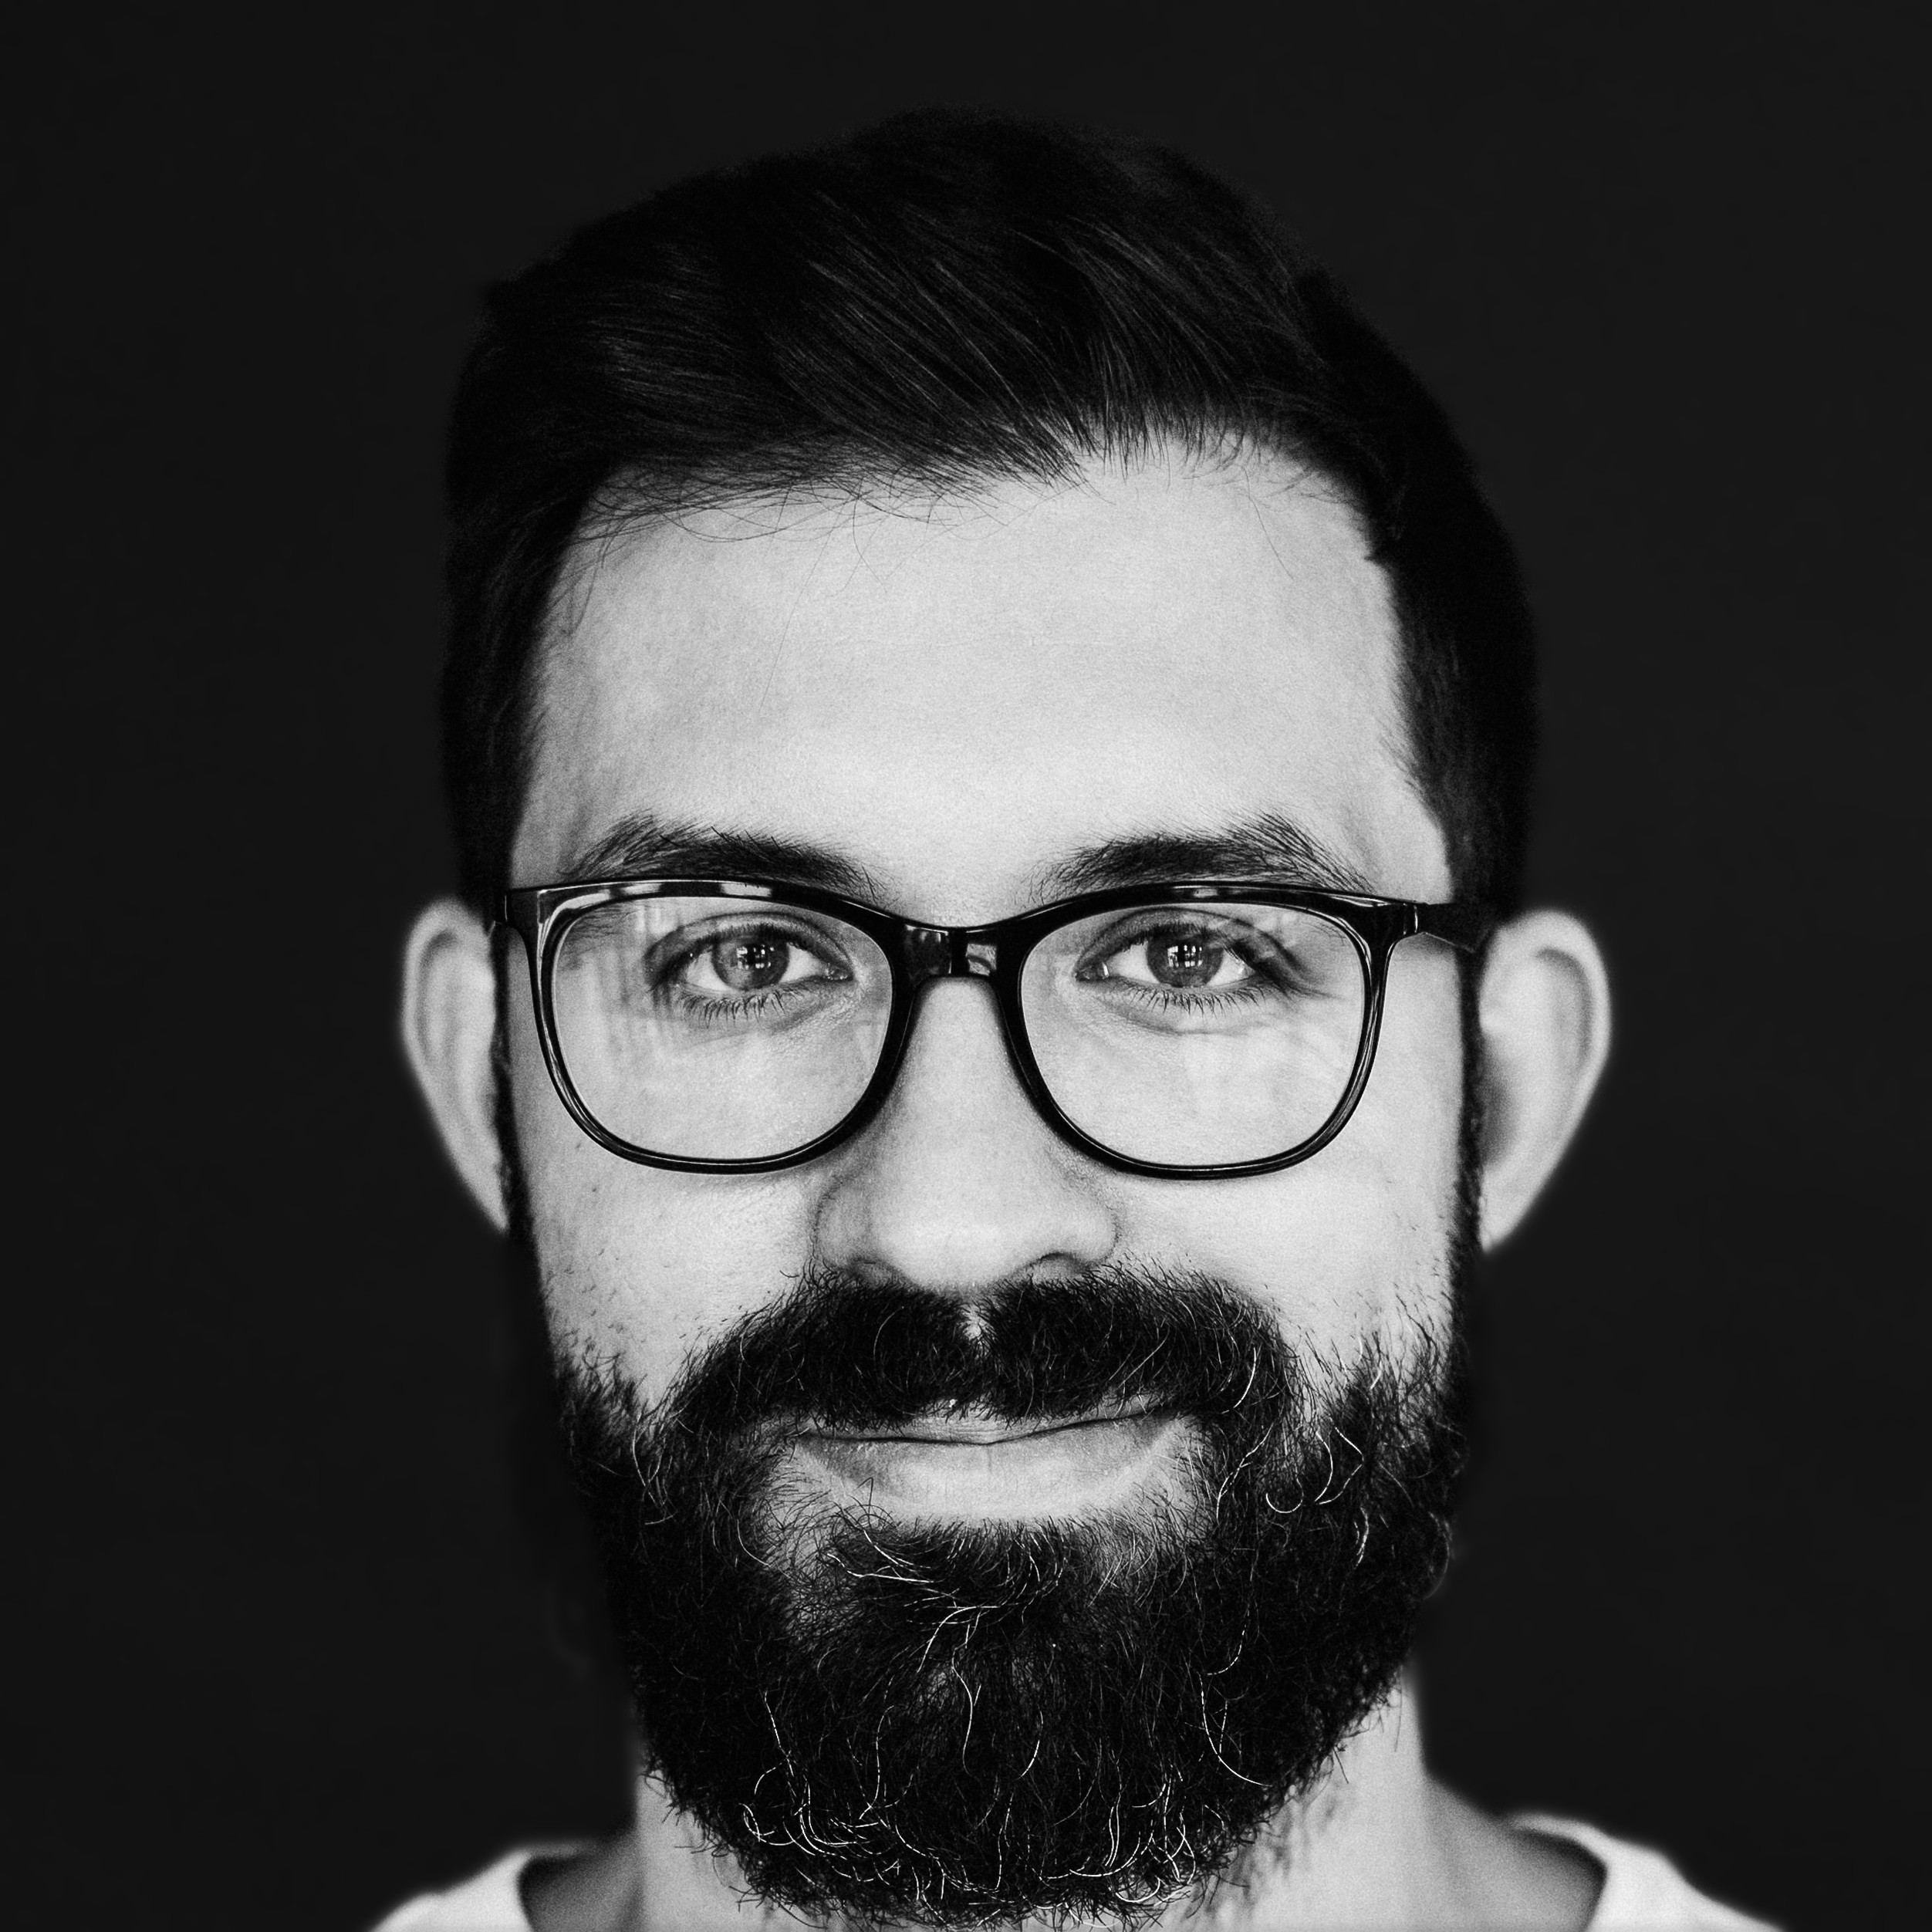

In [14]:
img

In [15]:
projector = Projector(gan)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/duke/anaconda3/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


In [40]:
x = projector.project(img, 256, label=0, lr_init=0.1, lpips_weight=1.0, vgg_weight=0.0, vgg_layer=15)

 iter 255, , lpips_loss: 0.13170582056045532: 100%|██████████| 256/256 [00:14<00:00, 17.91it/s]


In [41]:
with torch.no_grad():
    noise = gan.synthesis_net.make_noise(1)
    fake_img = make_image(gan.synthesis_net.forward(x, noise)[0])

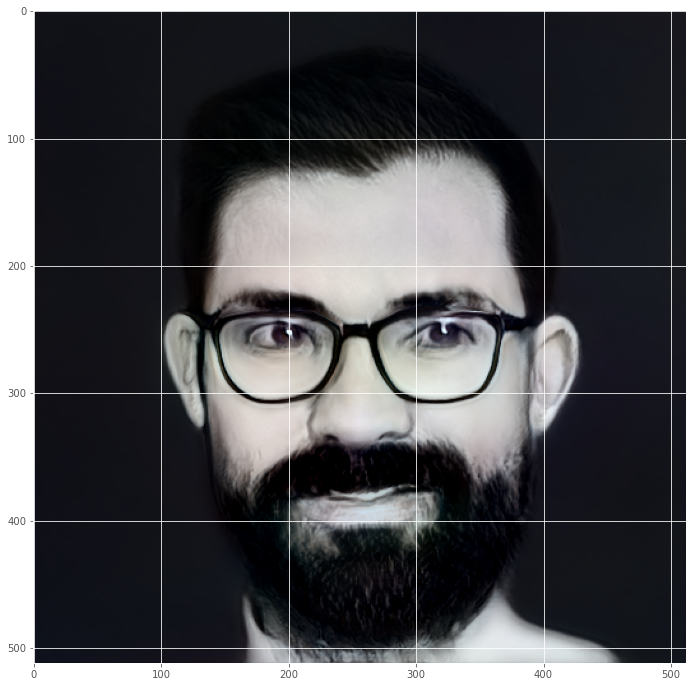

In [42]:
plt.imshow(fake_img)

In [46]:
np.save('ilya.npy', x.detach().cpu().numpy())

In [ ]:
_model = models.vgg16(pretrained=True)

In [ ]:
_model.features[:15]

In [ ]:
import tensorflow as tf